## Finding Ellipticities of CAMELS Galaxies and correlating Their Shape with Dark Matter Density.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors 
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
import h5py
import hdf5plugin
import treecorr
import time

In [11]:
filenum = 686
# Importing snapshot and catalogue data at redshift z=0
snapshot = f'C:\CAMELS DATA\LH{filenum}_snap_033IllustrisTNG.hdf5' # snapshot name
# open the snapshot
f = h5py.File(snapshot, 'r')
pos_dm = f['PartType1/Coordinates'][:]/1e3  #positions of dark matter in Mpc/h
pos_s = f['PartType4/Coordinates'][:]/1e3  # star positions in Mpc/h
mass_s = f['PartType4/Masses'][:]*1e10  # star masses in Mpc/h

# close file
f.close()
# catalogue name
catalogue = f'C:\CAMELS DATA\LH686_fof_subhalo_tab_033.hdf5'
# open the catalogue
f = h5py.File(catalogue, 'r')
# looking to see data in cataloge
# def print_dataset_name(name,g):
#     print(name,'&',g)
# f.visititems(print_dataset_name)
pos_sh  = f['Subhalo/SubhaloPos'][:]/1e3     #positions of SUBFIND subhalos in Mpc/h
subh_M_R_12 = f['Subhalo/SubhaloMassInRadType'][:,4]*1e10 # total stellar mass of twice the stellare alf-mass radius in Msun/h
nstar_h = f['Group/GroupLenType'][:,4]            # total number of stars in each halo
nstar_sh = f['Subhalo/SubhaloLenType'][:,4]            # total number of stars in each subhalo
n_subhalos = f['Group/GroupNsubs'][:]
# close file
f.close()

In [12]:
print('Total number of subhalos: ',np.sum(n_subhalos))
print("Total number of halos: ", len(n_subhalos))
print("Number of stars: ",len(pos_s))
print("Number of stars in halos: ",np.sum(nstar_h))
print("Number of stars in subhalos: ",np.sum(nstar_sh))

Total number of subhalos:  16298
Total number of halos:  18761
Number of stars:  264090
Number of stars in halos:  263587
Number of stars in subhalos:  263067


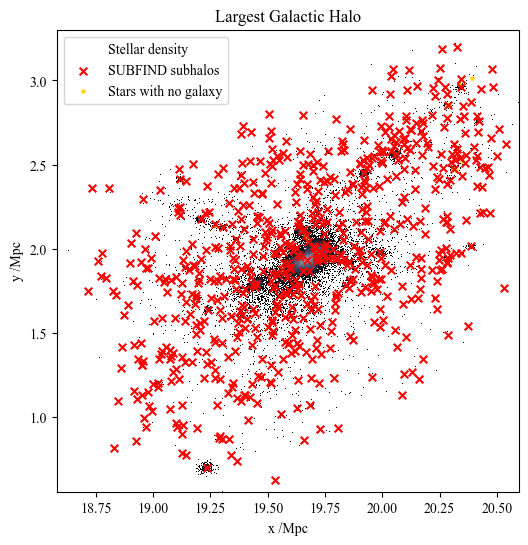

In [13]:
s_first_h = nstar_h[0] # number of stars in first halo
stop = s_first_h
s = n_subhalos[0] # number of subhalos in first halo
start = np.sum(nstar_sh[:s])
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
hist = ax.hist2d(pos_s[:stop, 1], pos_s[:stop, 0], cmap='bone', norm=colors.LogNorm(), bins=500)
sc1 = ax.scatter(pos_s[start:stop, 1], pos_s[start:stop, 0], marker='o', s=5, alpha=1.0, c='gold', label='Stars with no galaxy')
sc2 = ax.scatter(pos_sh[:s, 1], pos_sh[:s, 0], marker='x', s=30, alpha=1, c='r', label='SUBFIND subhalos')
ax.set_xlabel('x /Mpc')
ax.set_ylabel('y /Mpc')
ax.set_title('Largest Galactic Halo')
ax.set_box_aspect(1)

# Create a dummy artist for the hist2d plot to add it to the legend
dummy_artist = plt.Line2D([], [], linestyle='-', linewidth=1, color='white', label='Stellar density')
# Combine scatter plots and the dummy artist in the legend
handles = [dummy_artist, sc2, sc1]
labels = [handle.get_label() for handle in handles]
ax.legend(handles=handles, labels=labels)

plt.show()

#### Assigning every star to a subhalo according to SUBFIND algorithm
If a star does not belong to a subhalo but belongs to a halo, it does not get assigned an index. Stars which do not belong to any halo are at the end of the arrays thus do not get counted.

In [14]:
assigned = np.zeros(len(pos_s), dtype=bool) # Initialize an array to keep track of assigned star particles
# store the assignment of each star particle to a galaxy particle
assignment = -np.ones(len(pos_s), dtype=int)  # The index of the galaxy particle, for unassigned stars assignment =-1

begin_slice = 0
end_slice = nstar_sh[0] # end_slice - begin_silice = number of stars assigned to this subhalo w index subhalo_index
star_count = 0 # star index we are at
subhalo_index = 0   # subhalo index we are at

for i, number_sh in enumerate(n_subhalos): 
    if number_sh!=0: 
        for j in range(number_sh):          # looping through every subhalo in a halo
            
            assigned[begin_slice:end_slice] = True
            assignment[begin_slice:end_slice] = subhalo_index
            
            if nstar_sh[subhalo_index]!=0:
                begin_slice=end_slice
                end_slice = begin_slice + nstar_sh[subhalo_index+1]

            star_count += nstar_sh[subhalo_index]
            
            subhalo_index +=1

                

        old_star_count = star_count
        star_count = np.sum(nstar_h[:i+1])
        #print("unasigned stars: ", star_count - old_star_count)
        begin_slice = star_count   # skipping the stars with no subhalo
        if subhalo_index!=len(nstar_sh):
            end_slice = star_count+nstar_sh[subhalo_index]
    else:
        continue
print("It is",np.sum(n_subhalos)==subhalo_index, "we have counted all subhalos.")

It is True we have counted all subhalos.


Text(0, 0.5, 'subhalo index')

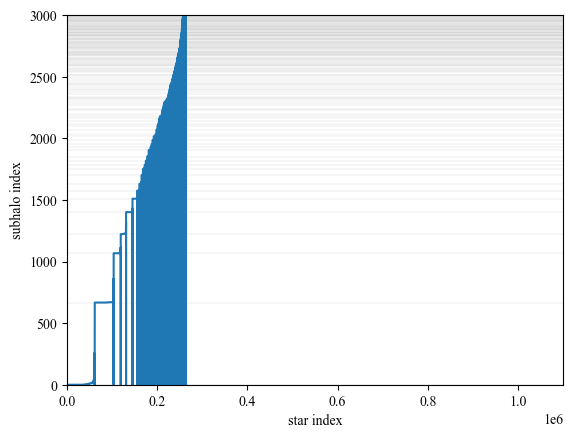

In [15]:
for __ in range(len(n_subhalos)):
    plt.axhline(np.sum(n_subhalos[:__]),c='0.5',linewidth=0.1)
plt.plot(assignment[:])
plt.xlim([0,1.1e6])
plt.ylim([0,3000])
plt.xlabel('star index')
plt.ylabel('subhalo index')

#### Galaxies are subhalos with Mstar > 1e8 Msun

In [28]:
# removing unasigned stars from star index
pos_s1 = pos_s[assigned]
mass_s1 = mass_s[assigned]
assignment1 = assignment[assigned]
# replacing subhalos with low stellar mass with np.nan
pos_g = pos_sh
pos_g[subh_M_R_12<1e8] = np.nan
nstar_g = nstar_sh.astype(float)
nstar_g[subh_M_R_12<1e8] = np.nan
print('Galaxy positions shape: ', pos_g.shape)

high_mass = np.where(subh_M_R_12>1e8)[0]
print(high_mass.shape, "galaxies")

# Create a boolean mask for the stars above the threshold mass
mask = np.isin(assignment1, high_mass)

# Filter out stars in subhalos below the threshold mass
pos_s2 = pos_s1[mask]
mass_s2 = mass_s1[mask]
filtered_assignment1 = assignment1[mask]
print("number of stars remaining:",filtered_assignment1.shape)

Galaxy positions shape:  (16298, 3)
(431,) galaxies
number of stars remaining: (258460,)


In [29]:
print(np.sort(nstar_g)[:10])
print(high_mass)

[10. 10. 10. 11. 12. 12. 12. 12. 12. 12.]
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   22   24   25   26   27   28   30
   31   33   40   42   44   46   49   50   51   54   57   58   63   66
   67   70   75   80   90   91   92  101  108  119  155  312  667  668
  669  670  671  672  673  674  675  677  678  683  689  693  694  695
  696  699  704  714  720  729  739  760  817  858  859  999 1067 1068
 1069 1070 1071 1072 1076 1079 1088 1089 1092 1097 1102 1103 1222 1223
 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1239 1257 1281
 1401 1402 1403 1404 1405 1406 1407 1410 1411 1412 1415 1510 1513 1514
 1515 1522 1575 1576 1583 1586 1631 1632 1633 1634 1635 1701 1712 1751
 1752 1754 1758 1784 1785 1786 1787 1788 1818 1819 1820 1852 1853 1854
 1905 1906 1928 1929 1931 1932 1951 1952 1984 1985 1986 1987 2017 2033
 2034 2068 2069 2070 2102 2103 2114 2115 2116 2117 2138 2140 2161 2162
 2179 2180 2181 2182 2200 2201 2202